# JAX tutorial 

* JAX offers four benefits for scientists writing pipelines in cosmology:

** Just In Time (JIT) compilation
** Automatic differentiation
** Easy vectorization
** GPU acceleration

* In this notebook we will see examples of the first two and talk a bit about the thirs though this requires compatible hardware.


In [1]:
## Standard libraries
import os
import math
import numpy as np 
import time

## Imports for plotting
import matplotlib.pyplot as plt
%matplotlib inline 
import getdist

## cosmological sampling 
import numpyro 
import emcee 

## JAX 
import jax
import jax.numpy as jnp

## Emulator library- This is written by me and the details are not too important for this tutorial 
## essentially the idea is to have a fast emulator for the WL power spectrum written in JAX 
from integrated_model_jax import IntegratedModel

## Lets look at a common example in cosmology: sampling a posterior 

* First lets load in an Emulator in JAX that I pre-trained to output the KiDS WL $C_\ell$s

In [2]:

wl_model = IntegratedModel(None, None, None, None)
wl_model.restore("wl_fiducial_2048")
cov = np.load("covmat.npy")

scaler mean shape (15,)
scaler mean out shape (120,)
no pca
no pca
restore successful


Now lets choose some fiducial cosmology to match planck18 and make some fake data 

In [3]:
# Emulator takes normal LCDM parameters plus some nuisances: a $A_{IA}$ parameter, and 5 photo-z nuisance parameters
fid_cosmo = {'omega_b': jnp.array([0.02235]), 'omega_cdm': jnp.array([0.120]), 'h': jnp.array([0.675]), 'sigma8':jnp.array([0.811]), 'n_s': jnp.array([0.965]), 'A_IA':jnp.array([0]), 'del_z1':jnp.array([0.0]),\
             'del_z2':jnp.array([0.0]), 'del_z3':jnp.array([0.0]), 'del_z4':jnp.array([0.0]), 
             'del_z5':jnp.array([0.0]), 'logT_AGN':jnp.array([7.8]), 'm_nu':jnp.array([0.02]), 'bias_l1':jnp.array([1.0]), 'bias_c2':jnp.array([1.0])}

# The emulator also takes EDE parameters which are not used in this example so set fEDE to 0.0
fid_cosmo["fEDE"] = jnp.array([0.0])
fid_cosmo["log10z_c"] = jnp.array([3.3])
fid_cosmo["thetai_scf"] = jnp.array([2.0])

datavector = wl_model.predict(fid_cosmo)[0]

Plotting the data we will fit 

<ErrorbarContainer object of 3 artists>

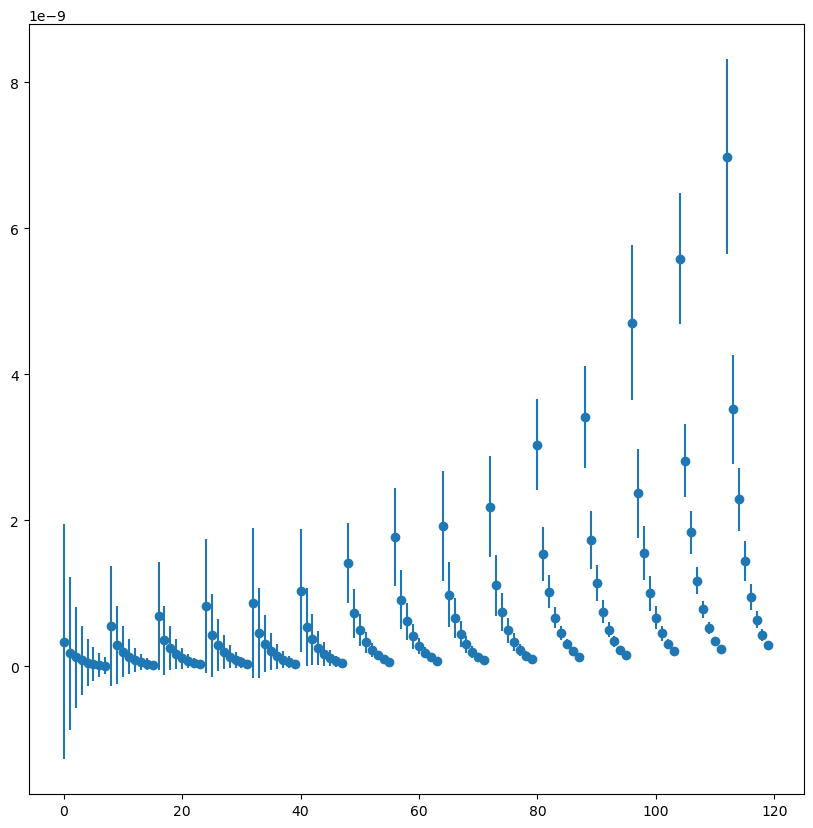

In [4]:
fig, ax = plt.subplots(figsize=(10,10))
ax.errorbar(x=np.arange(120), y=datavector, yerr=np.sqrt(np.diag(cov)), fmt='o')

Now lets see why JAX is useful: lets write the likelihood in JAX

In [5]:
params_vary =["omega_b", "omega_cdm", "h", "sigma8", "n_s", "A_IA", "del_z1", "del_z2", "del_z3", "del_z4", "del_z5"]
def create_emu_input_dict(params):
    emu_input = fid_cosmo.copy()
    for i, p in enumerate(params_vary):
        emu_input[p] = params[i]
    return emu_input


inv_cov = jnp.linalg.inv(jnp.array(cov))

In [6]:
def loglkl(params):
    emu_input = create_emu_input_dict(params)
    theory_prediction = wl_model.predict(emu_input)[0]
    diff = theory_prediction - datavector
    return -0.5 * jnp.dot(diff, jnp.dot(inv_cov, diff))

Now lets see the benefit of JIT compilation

In [7]:
#how log does the unjitted code take to run? 
dummy_input = jnp.array([[0.02235, 0.120, 0.675, 0.811, 0.965, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]])
%timeit loglkl(dummy_input) #This is already pretty quick for such a simple likelihood

6.09 ms ± 170 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [11]:
# now lets JIT this function, this is as simple as

lkl_jit = jax.jit(loglkl)

# Need to run the function one for compilation to take place 
lkl_jit(dummy_input)

Array(-907.5675, dtype=float32)

In [12]:
%timeit lkl_jit(dummy_input)

216 µs ± 298 ns per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


Great now all thats left to do is sampling 